In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,BatchNormalization, Normalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from sklearn.preprocessing import normalize

In [83]:
df = pd.read_csv('train.csv', index_col='id')
df

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D


In [100]:
# Separamos en variables dependientes y independientes
X = df.drop('Status', axis=1)
y = df['Status']

### Algunas ingenieria de variables

In [24]:
class Age_Format (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self
    
    # Iteramos por el nombre de columna de Age, calculando el valor real edad desde los dias de nacimiento de cada paciente.
    def transform(self,X):
        X_copy = X.copy()
        
        new_age = []
        for i in X_copy['Age']:
            days = i
            age = days/365
            new_age.append(round(age))
        
        X_copy = X_copy.drop('Age', axis = 1)
        X_copy['Age'] = new_age
        
        return X_copy

In [85]:
Age_ = Age_Format()
X = Age_.transform(X)

In [66]:
class Sgot_Range (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self
    
    # Iteramos por el nombre de columna de Sgot, calculando en base a analisis, los pacientes con mayor o menor
    # rango. Si supera el nivel 100, se marcara como 1, en caso contrario 0
    def transform(self,X):
        X_copy = X.copy()
        
        Sgot_survival = []
        for i in X_copy['SGOT']:
            if i > 100:
                Sgot_survival.append(1)
            else: Sgot_survival.append(0)
        
        X_copy['Sgot_survival'] = Sgot_survival
        
        return X_copy

In [86]:
Sgot_ =  Sgot_Range()
X = Sgot_.transform(X)

In [49]:
class Bilirubin_Range (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self
    
    # Iteramos por el nombre de columna de Bilirubin, calculando en base a analisis, los pacientes con mayor o menor
    # rango. Si supera el nivel 3, se marcara como 1, en caso contrario 0
    def transform(self,X):
        X_copy = X.copy()
        
        Bilirubin_survival = []
        for i in X_copy['Bilirubin']:
            if i > 1.5:
                Bilirubin_survival.append(1)
            else: Bilirubin_survival.append(0)
        
        X_copy['Bilirubin_survival'] = Bilirubin_survival
        
        return X_copy

In [87]:
Bilirubin_ = Bilirubin_Range()
X = Bilirubin_.transform(X)

In [41]:
class Copper_Range (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self
    
    # Iteramos por el nombre de columna de Copper, calculando en base a analisis, los pacientes con mayor o menor
    # rango. Si supera el nivel 60, se marcara como 1, en caso contrario 0
    def transform(self,X):
        X_copy = X.copy()
        
        Copper_survival = []
        for i in X_copy['Copper']:
            if i >= 60:
                Copper_survival.append(1)
            else: Copper_survival.append(0)
        
        X_copy['Copper_survival'] = Copper_survival
        
        return X_copy

In [88]:
Copper_ = Copper_Range()
X = Copper_.transform(X)

### Transformacion distribucion de variables 

In [82]:
class Tranformation_Distribution (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self
    
    # Iteramos por el nombre de columna de X_copy, devolviendo el valor devuelto por boxcox (no el valor lambda).
    def transform(self,X):
        X_copy = X.copy()    
        column_names = ['Bilirubin','Cholesterol','Copper','Alk_Phos','SGOT','Tryglicerides','Prothrombin']
        
        for i in column_names:
            transformed_col,_ = stats.boxcox(X_copy[i])
            X_copy[i] = transformed_col
        
        X_copy = X_copy.drop('N_Days', axis = 1)
        return X_copy

In [89]:
transformers_ = Tranformation_Distribution()
X = transformers_.transform(X)

In [90]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Drug                7905 non-null   object 
 1   Sex                 7905 non-null   object 
 2   Ascites             7905 non-null   object 
 3   Hepatomegaly        7905 non-null   object 
 4   Spiders             7905 non-null   object 
 5   Edema               7905 non-null   object 
 6   Bilirubin           7905 non-null   float64
 7   Cholesterol         7905 non-null   float64
 8   Albumin             7905 non-null   float64
 9   Copper              7905 non-null   float64
 10  Alk_Phos            7905 non-null   float64
 11  SGOT                7905 non-null   float64
 12  Tryglicerides       7905 non-null   float64
 13  Platelets           7905 non-null   float64
 14  Prothrombin         7905 non-null   float64
 15  Stage               7905 non-null   float64
 16  Age        

### Pipeline de procesado de datos

In [101]:
numerical_columns = ['Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos',
                     'SGOT','Tryglicerides','Platelets','Prothrombin','Stage', 'Age']
categorical_columns = X.select_dtypes(exclude='number')

# Automatizado de clases con funciones de ingenieria de variables.
class_pipeline = make_pipeline(Age_, Sgot_, Bilirubin_, Copper_, transformers_)

# automatizado de transformacion categoricas y numericas (Normalizado y OneHot)
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse_output=False, drop='first'))
numerical_pipeline = make_pipeline(MinMaxScaler())

preprocessing = ColumnTransformer([
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns.columns),
], remainder='passthrough')

# Unimos en un pipeline global
pipeline_full = make_pipeline(class_pipeline, preprocessing)

X_processed = pipeline_full.fit_transform(X)
X_processed

array([[0.70391991, 0.61188349, 0.51865672, ..., 1.        , 1.        ,
        1.        ],
       [0.46256772, 0.66758531, 0.58955224, ..., 1.        , 0.        ,
        1.        ],
       [0.77138408, 0.58831218, 0.59328358, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.67449227, 0.44900595, 0.45895522, ..., 0.        , 1.        ,
        0.        ],
       [0.37719491, 0.50032879, 0.29477612, ..., 0.        , 0.        ,
        0.        ],
       [0.37719491, 0.51621679, 0.4738806 , ..., 0.        , 0.        ,
        0.        ]])

In [102]:
# Extraemos nombre de columnas del ultimo paso de la pipeline
columns = preprocessing.get_feature_names_out()
# Creamos df de X_processed
X_original = pd.DataFrame(X_processed, columns = columns)
X_original

,num__Bilirubin,num__Cholesterol,num__Albumin,num__Copper,num__Alk_Phos,num__SGOT,num__Tryglicerides,num__Platelets,num__Prothrombin,num__Stage,...,cat__Drug_Placebo,cat__Sex_M,cat__Ascites_Y,cat__Hepatomegaly_Y,cat__Spiders_Y,cat__Edema_S,cat__Edema_Y,remainder__Sgot_survival,remainder__Bilirubin_survival,remainder__Copper_survival
0,0.703920,0.611883,0.518657,0.751284,0.668167,0.675003,0.297584,0.662675,0.270725,0.666667,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.462568,0.667585,0.589552,0.549236,0.641062,0.574429,0.431628,0.596806,0.580596,0.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.771384,0.588312,0.593284,0.696402,0.545185,0.531684,0.197319,0.273453,0.685430,1.000000,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,0.319490,0.516217,0.574627,0.532648,0.676068,0.350958,0.464528,0.413174,0.524815,0.666667,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.523705,0.648336,0.630597,0.549236,0.586411,0.549417,0.464528,0.471058,0.504469,1.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,0.423839,0.602462,0.597015,0.447931,0.672468,0.387205,0.746485,0.562874,0.331830,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7901,0.462568,0.523829,0.548507,0.546026,0.641062,0.592505,0.384677,0.429142,0.360187,1.000000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
7902,0.674492,0.449006,0.458955,0.506860,0.514139,0.343234,0.290848,0.275449,0.791054,0.333333,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7903,0.377195,0.500329,0.294776,0.413554,0.537216,0.274392,0.539435,0.317365,0.504469,1.000000,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# codificamos y
scaler_y = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [104]:
encoded_y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [ ]:
# validacion y entrenamiento
X_train,X_test,y_train,y_test = train_test_split(X_original, encoded_y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

### Prediccion con redes

In [158]:
# Arquitectura de red
tf.random.set_seed(42)

modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu', input_dim=21),
    BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(25, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dense(25, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation='softmax'),
])

optimizador = tf.keras.optimizers.Adam(learning_rate=0.0005)
modelo.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])

modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                550       
                                                                 
 batch_normalization_3 (Bat  (None, 25)                100       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 batch_normalization_4 (Bat  (None, 25)                100       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 25)               

In [159]:
# Ajustar y entrenar el modelo de red neuronal
early_stop = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
filepath='./checkpoints/checkpoint'
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,save_best_only=True, save_weigth_only=False, 
                                                monitor='val_loss', mode='min')
history=modelo.fit(X_train, y_train ,batch_size= 35, callbacks=[early_stop, best_model] ,epochs=400,validation_data=(X_test, y_test))

Epoch 1/400


175/181 [============================>.] - ETA: 0s - loss: 1.3770 - accuracy: 0.4424INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 4s 13ms/step - loss: 1.3624 - accuracy: 0.4477 - val_loss: 0.9463 - val_accuracy: 0.5712
Epoch 2/400
171/181 [===========================>..] - ETA: 0s - loss: 1.0063 - accuracy: 0.5830INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 12ms/step - loss: 1.0043 - accuracy: 0.5841 - val_loss: 0.7044 - val_accuracy: 0.7710
Epoch 3/400
161/181 [=========================>....] - ETA: 0s - loss: 0.8318 - accuracy: 0.6605INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.8248 - accuracy: 0.6662 - val_loss: 0.6148 - val_accuracy: 0.7812
Epoch 4/400
163/181 [==========================>...] - ETA: 0s - loss: 0.7715 - accuracy: 0.7029INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.7638 - accuracy: 0.7064 - val_loss: 0.5759 - val_accuracy: 0.7862
Epoch 5/400
169/181 [===========================>..] - ETA: 0s - loss: 0.7176 - accuracy: 0.7276INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.7162 - accuracy: 0.7282 - val_loss: 0.5495 - val_accuracy: 0.7938
Epoch 6/400
179/181 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.7405INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.6750 - accuracy: 0.7407 - val_loss: 0.5363 - val_accuracy: 0.7995
Epoch 7/400
178/181 [============================>.] - ETA: 0s - loss: 0.6560 - accuracy: 0.7568INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.6558 - accuracy: 0.7562 - val_loss: 0.5289 - val_accuracy: 0.8008
Epoch 8/400
172/181 [===========================>..] - ETA: 0s - loss: 0.6420 - accuracy: 0.7518INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.6376 - accuracy: 0.7536 - val_loss: 0.5233 - val_accuracy: 0.8008
Epoch 9/400
174/181 [===========================>..] - ETA: 0s - loss: 0.6302 - accuracy: 0.7573INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.6277 - accuracy: 0.7593 - val_loss: 0.5214 - val_accuracy: 0.8033
Epoch 10/400
172/181 [===========================>..] - ETA: 0s - loss: 0.6033 - accuracy: 0.7718INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 13ms/step - loss: 0.6073 - accuracy: 0.7687 - val_loss: 0.5156 - val_accuracy: 0.8065
Epoch 11/400
171/181 [===========================>..] - ETA: 0s - loss: 0.6061 - accuracy: 0.7686INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.6059 - accuracy: 0.7693 - val_loss: 0.5149 - val_accuracy: 0.8058
Epoch 12/400
168/181 [==========================>...] - ETA: 0s - loss: 0.6003 - accuracy: 0.7702INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5983 - accuracy: 0.7707 - val_loss: 0.5131 - val_accuracy: 0.8102
Epoch 13/400
174/181 [===========================>..] - ETA: 0s - loss: 0.6002 - accuracy: 0.7747INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5967 - accuracy: 0.7751 - val_loss: 0.5107 - val_accuracy: 0.8134
Epoch 14/400
168/181 [==========================>...] - ETA: 0s - loss: 0.5906 - accuracy: 0.7680INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5888 - accuracy: 0.7694 - val_loss: 0.5093 - val_accuracy: 0.8140
Epoch 15/400
164/181 [==========================>...] - ETA: 0s - loss: 0.5788 - accuracy: 0.7784INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5835 - accuracy: 0.7766 - val_loss: 0.5077 - val_accuracy: 0.8153
Epoch 16/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5933 - accuracy: 0.7725 - val_loss: 0.5086 - val_accuracy: 0.8147
Epoch 17/400
166/181 [==========================>...] - ETA: 0s - loss: 0.5793 - accuracy: 0.7764INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5764 - accuracy: 0.7785 - val_loss: 0.5054 - val_accuracy: 0.8153
Epoch 18/400
168/181 [==========================>...] - ETA: 0s - loss: 0.5811 - accuracy: 0.7844INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 13ms/step - loss: 0.5800 - accuracy: 0.7857 - val_loss: 0.5049 - val_accuracy: 0.8140
Epoch 19/400
178/181 [============================>.] - ETA: 0s - loss: 0.5801 - accuracy: 0.7777INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5794 - accuracy: 0.7780 - val_loss: 0.5042 - val_accuracy: 0.8121
Epoch 20/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5724 - accuracy: 0.7805 - val_loss: 0.5052 - val_accuracy: 0.8128
Epoch 21/400
176/181 [============================>.] - ETA: 0s - loss: 0.5666 - accuracy: 0.7805INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5682 - accuracy: 0.7794 - val_loss: 0.5034 - val_accuracy: 0.8128
Epoch 22/400
180/181 [============================>.] - ETA: 0s - loss: 0.5710 - accuracy: 0.7817INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5709 - accuracy: 0.7818 - val_loss: 0.5020 - val_accuracy: 0.8153
Epoch 23/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5708 - accuracy: 0.7826 - val_loss: 0.5035 - val_accuracy: 0.8115
Epoch 24/400
178/181 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.7830INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5624 - accuracy: 0.7826 - val_loss: 0.5018 - val_accuracy: 0.8140
Epoch 25/400
170/181 [===========================>..] - ETA: 0s - loss: 0.5676 - accuracy: 0.7871INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5651 - accuracy: 0.7875 - val_loss: 0.5010 - val_accuracy: 0.8159
Epoch 26/400
166/181 [==========================>...] - ETA: 0s - loss: 0.5617 - accuracy: 0.7878INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5667 - accuracy: 0.7854 - val_loss: 0.4988 - val_accuracy: 0.8178
Epoch 27/400
180/181 [============================>.] - ETA: 0s - loss: 0.5629 - accuracy: 0.7851INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5632 - accuracy: 0.7849 - val_loss: 0.4975 - val_accuracy: 0.8166
Epoch 28/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5617 - accuracy: 0.7914 - val_loss: 0.4999 - val_accuracy: 0.8185
Epoch 29/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5657 - accuracy: 0.7925 - val_loss: 0.4983 - val_accuracy: 0.8178
Epoch 30/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5645 - accuracy: 0.7887 - val_loss: 0.4985 - val_accuracy: 0.8197
Epoch 31/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5559 - accuracy: 0.7883 - val_loss: 0.4982 - val_accuracy: 0.8197
Epoch 32/400
176/181 [============================>.] - ETA: 0s - loss: 0.5597 - accuracy: 0.7893INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 13ms/step - loss: 0.5583 - accuracy: 0.7900 - val_loss: 0.4968 - val_accuracy: 0.8204
Epoch 33/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5543 - accuracy: 0.7906 - val_loss: 0.4971 - val_accuracy: 0.8210
Epoch 34/400
181/181 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.7894INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5549 - accuracy: 0.7894 - val_loss: 0.4965 - val_accuracy: 0.8197
Epoch 35/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5525 - accuracy: 0.7895 - val_loss: 0.4979 - val_accuracy: 0.8197
Epoch 36/400
174/181 [===========================>..] - ETA: 0s - loss: 0.5447 - accuracy: 0.7910INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5499 - accuracy: 0.7897 - val_loss: 0.4952 - val_accuracy: 0.8178
Epoch 37/400
166/181 [==========================>...] - ETA: 0s - loss: 0.5545 - accuracy: 0.7916INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5561 - accuracy: 0.7922 - val_loss: 0.4932 - val_accuracy: 0.8197
Epoch 38/400
170/181 [===========================>..] - ETA: 0s - loss: 0.5519 - accuracy: 0.7891INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5502 - accuracy: 0.7886 - val_loss: 0.4932 - val_accuracy: 0.8197
Epoch 39/400
165/181 [==========================>...] - ETA: 0s - loss: 0.5545 - accuracy: 0.7919INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5558 - accuracy: 0.7927 - val_loss: 0.4930 - val_accuracy: 0.8204
Epoch 40/400
172/181 [===========================>..] - ETA: 0s - loss: 0.5544 - accuracy: 0.7952INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5509 - accuracy: 0.7974 - val_loss: 0.4919 - val_accuracy: 0.8235
Epoch 41/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5578 - accuracy: 0.7878 - val_loss: 0.4921 - val_accuracy: 0.8210
Epoch 42/400
176/181 [============================>.] - ETA: 0s - loss: 0.5526 - accuracy: 0.7907INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5503 - accuracy: 0.7914 - val_loss: 0.4910 - val_accuracy: 0.8216
Epoch 43/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5498 - accuracy: 0.7903 - val_loss: 0.4922 - val_accuracy: 0.8210
Epoch 44/400
169/181 [===========================>..] - ETA: 0s - loss: 0.5495 - accuracy: 0.7909INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 13ms/step - loss: 0.5495 - accuracy: 0.7911 - val_loss: 0.4903 - val_accuracy: 0.8216
Epoch 45/400
167/181 [==========================>...] - ETA: 0s - loss: 0.5514 - accuracy: 0.7926INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5487 - accuracy: 0.7941 - val_loss: 0.4901 - val_accuracy: 0.8223
Epoch 46/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5488 - accuracy: 0.7911 - val_loss: 0.4913 - val_accuracy: 0.8223
Epoch 47/400
176/181 [============================>.] - ETA: 0s - loss: 0.5465 - accuracy: 0.7909INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5463 - accuracy: 0.7911 - val_loss: 0.4897 - val_accuracy: 0.8210
Epoch 48/400
172/181 [===========================>..] - ETA: 0s - loss: 0.5530 - accuracy: 0.7895INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5486 - accuracy: 0.7917 - val_loss: 0.4889 - val_accuracy: 0.8235
Epoch 49/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5478 - accuracy: 0.7948 - val_loss: 0.4895 - val_accuracy: 0.8242
Epoch 50/400
172/181 [===========================>..] - ETA: 0s - loss: 0.5468 - accuracy: 0.7910INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5488 - accuracy: 0.7908 - val_loss: 0.4885 - val_accuracy: 0.8248
Epoch 51/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5416 - accuracy: 0.7936 - val_loss: 0.4894 - val_accuracy: 0.8229
Epoch 52/400
178/181 [============================>.] - ETA: 0s - loss: 0.5431 - accuracy: 0.7945INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5428 - accuracy: 0.7954 - val_loss: 0.4864 - val_accuracy: 0.8229
Epoch 53/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5448 - accuracy: 0.7910 - val_loss: 0.4865 - val_accuracy: 0.8242
Epoch 54/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5472 - accuracy: 0.7906 - val_loss: 0.4868 - val_accuracy: 0.8261
Epoch 55/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5490 - accuracy: 0.7906 - val_loss: 0.4894 - val_accuracy: 0.8235
Epoch 56/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5429 - accuracy: 0.7911 - val_loss: 0.4870 - val_accuracy: 0.8235
Epoch 57/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5402 - accuracy: 0.7929 - val_loss: 0.4875 - val_accuracy: 0.8216
Epoch 58/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5426 - accuracy: 0.7917 - val_loss: 0.4866 - val_accuracy: 0.8204
Epoc

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5439 - accuracy: 0.7930 - val_loss: 0.4856 - val_accuracy: 0.8242
Epoch 60/400
169/181 [===========================>..] - ETA: 0s - loss: 0.5443 - accuracy: 0.7853INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 13ms/step - loss: 0.5419 - accuracy: 0.7870 - val_loss: 0.4855 - val_accuracy: 0.8235
Epoch 61/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5375 - accuracy: 0.7959 - val_loss: 0.4858 - val_accuracy: 0.8210
Epoch 62/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5415 - accuracy: 0.7936 - val_loss: 0.4867 - val_accuracy: 0.8172
Epoch 63/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5395 - accuracy: 0.7935 - val_loss: 0.4863 - val_accuracy: 0.8191
Epoch 64/400
176/181 [============================>.] - ETA: 0s - loss: 0.5385 - accuracy: 0.7907INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5385 - accuracy: 0.7903 - val_loss: 0.4845 - val_accuracy: 0.8210
Epoch 65/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5367 - accuracy: 0.7944 - val_loss: 0.4858 - val_accuracy: 0.8235
Epoch 66/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5459 - accuracy: 0.7900 - val_loss: 0.4852 - val_accuracy: 0.8191
Epoch 67/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5448 - accuracy: 0.7908 - val_loss: 0.4848 - val_accuracy: 0.8223
Epoch 68/400
177/181 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.7942INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5451 - accuracy: 0.7938 - val_loss: 0.4844 - val_accuracy: 0.8216
Epoch 69/400
175/181 [============================>.] - ETA: 0s - loss: 0.5349 - accuracy: 0.7959INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 11ms/step - loss: 0.5381 - accuracy: 0.7957 - val_loss: 0.4838 - val_accuracy: 0.8204
Epoch 70/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5386 - accuracy: 0.7922 - val_loss: 0.4846 - val_accuracy: 0.8210
Epoch 71/400
176/181 [============================>.] - ETA: 0s - loss: 0.5376 - accuracy: 0.7937INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


181/181 [==============================] - 2s 10ms/step - loss: 0.5385 - accuracy: 0.7932 - val_loss: 0.4826 - val_accuracy: 0.8229
Epoch 72/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5364 - accuracy: 0.7979 - val_loss: 0.4842 - val_accuracy: 0.8235
Epoch 73/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5384 - accuracy: 0.7921 - val_loss: 0.4826 - val_accuracy: 0.8235
Epoch 74/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5383 - accuracy: 0.7933 - val_loss: 0.4854 - val_accuracy: 0.8191
Epoch 75/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5356 - accuracy: 0.7979 - val_loss: 0.4833 - val_accuracy: 0.8248
Epoch 76/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5390 - accuracy: 0.7924 - val_loss: 0.4848 - val_accuracy: 0.8210
Epoch 77/400
181/181 [==============================] - 1s 3ms/step - loss: 0.5432 - accuracy: 0.7900 - val_loss: 0.4849 - val_accuracy: 0.8216
Epoc

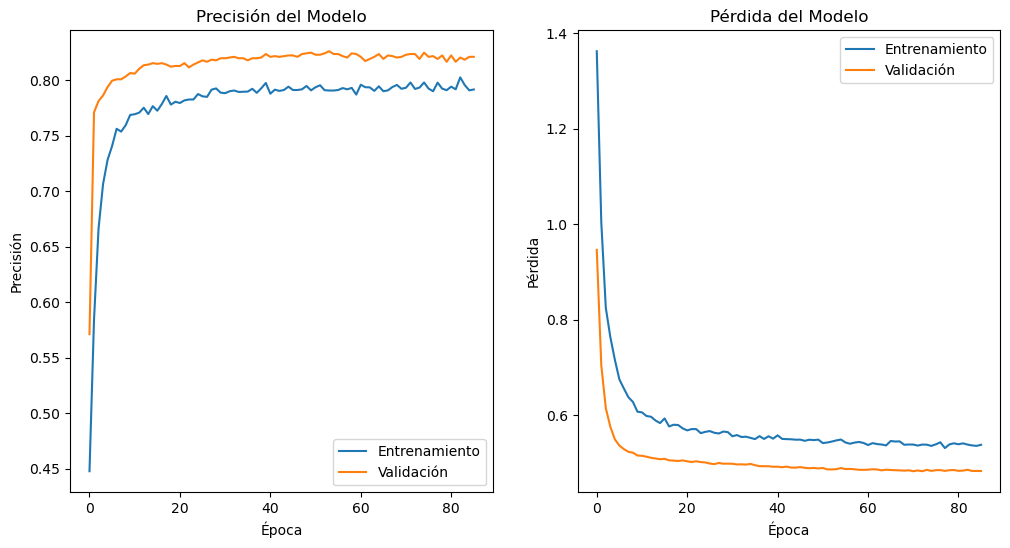

In [160]:
plt.figure(figsize=(12, 6))

# Plot Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Plot Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [161]:
best_model = load_model('./checkpoints/checkpoint')

In [162]:
resultados = best_model.evaluate(X_test, y_test)

50/50 [==============================] - 0s 2ms/step - loss: 0.4826 - accuracy: 0.8229


### Prediccion de los datos de prueba

In [163]:
X_prueba = pd.read_csv('test.csv')
X_prueba

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13171,2870,Placebo,12279,F,N,N,N,N,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0
5267,13172,1770,Placebo,24803,F,N,N,N,N,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0
5268,13173,3707,D-penicillamine,16990,F,N,Y,N,N,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0
5269,13174,1216,Placebo,11773,F,N,N,N,N,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0


In [164]:
id_ = X_prueba['id']
X_prueba = X_prueba.drop('id', axis =1)

In [165]:
# Procesamos con pipeline los datos nuevos
X_prueba = pipeline_full.fit_transform(X_prueba)
X_prueba

array([[0.548898, 0.80213 , 0.526119, ..., 1.      , 0.      , 1.      ],
       [0.524165, 0.848367, 0.843284, ..., 1.      , 0.      , 1.      ],
       [0.67494 , 0.19498 , 0.373134, ..., 0.      , 1.      , 0.      ],
       ...,
       [0.424264, 0.618151, 0.794776, ..., 1.      , 0.      , 0.      ],
       [0.377594, 0.63596 , 0.686567, ..., 0.      , 0.      , 0.      ],
       [0.67494 , 0.472877, 0.544776, ..., 1.      , 1.      , 0.      ]])

In [166]:
X_prueba.shape

(5271, 21)

In [167]:
# Predecimos con nuestor modelo ya entrenado
prueba_prediction = best_model.predict(X_prueba)
prueba_prediction

165/165 [==============================] - 0s 2ms/step


array([[0.675244, 0.035691, 0.289065],
       [0.883186, 0.041629, 0.075185],
       [0.078888, 0.022945, 0.898166],
       ...,
       [0.842841, 0.024974, 0.132185],
       [0.957868, 0.017807, 0.024326],
       [0.264131, 0.039765, 0.696104]], dtype=float32)

In [168]:
# Guardar en listas cada etiqueta con la probabilidad
Status_C = []
Status_CL = []
Status_D = []
for i in range(len(prueba_prediction)):
    Status_C.append(prueba_prediction[i, 0])
    Status_CL.append(prueba_prediction[i, 1])
    Status_D.append(prueba_prediction[i, 2])

In [169]:
# Creamos la submission
submission_test = {'id': id_, 'Status_C':Status_C, 'Status_CL':Status_CL,'Status_D':Status_D}

In [170]:
data = pd.DataFrame(submission_test)
data

,id,Status_C,Status_CL,Status_D
0,7905,0.675244,0.035691,0.289065
1,7906,0.883186,0.041629,0.075185
2,7907,0.078888,0.022945,0.898166
3,7908,0.915902,0.014171,0.069927
4,7909,0.791387,0.023647,0.184966
...,...,...,...,...
5266,13171,0.874874,0.033821,0.091305
5267,13172,0.939146,0.007545,0.053309
5268,13173,0.842841,0.024974,0.132185
5269,13174,0.957868,0.017807,0.024326


In [171]:
#Guardamos
data.to_csv('prediction_V2.csv', index=False)